e:\Apps\anaconda3\envs\iag\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\Apps\anaconda3\envs\iag\lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


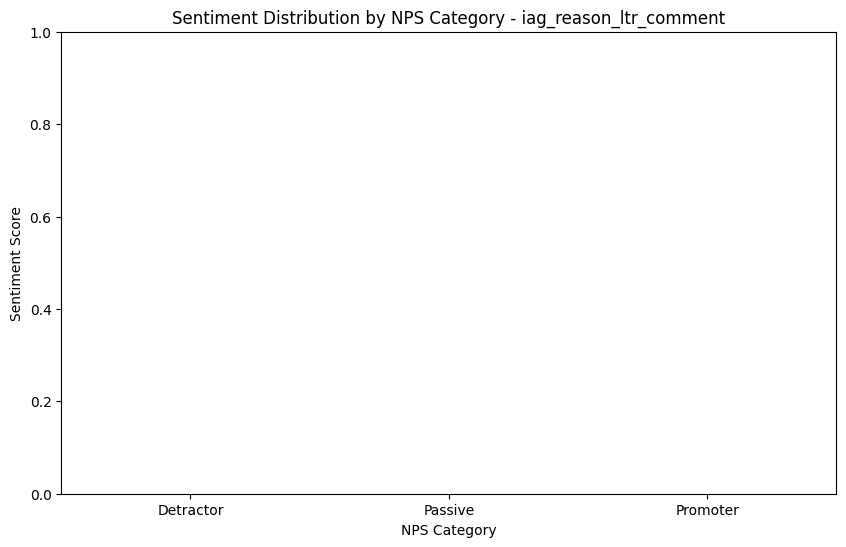


Top 20 most important words in iag_reason_ltr_comment:
         word  tfidf_score
2       claim     0.092496
9     helpful     0.092059
15    service     0.072072
12      phone     0.070499
6    friendly     0.068377
4        easy     0.053441
11     person     0.051843
17      staff     0.050544
7        good     0.037519
13    process     0.034603
19       time     0.033586
10       lady     0.033555
8       great     0.032100
14      quick     0.031463
3    customer     0.031174
16      spoke     0.029783
5   efficient     0.029525
18      state     0.023345
0         ami     0.021036
1         car     0.019903


e:\Apps\anaconda3\envs\iag\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\Apps\anaconda3\envs\iag\lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


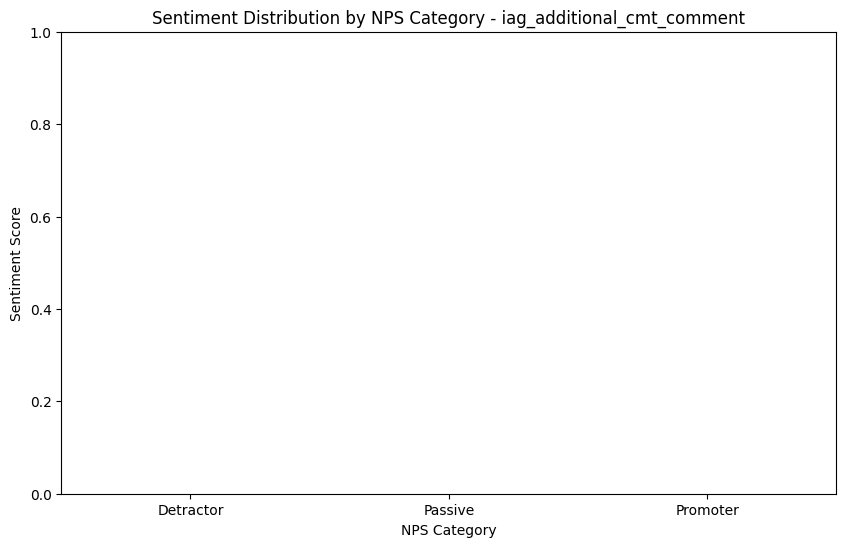


Top 20 most important words in iag_additional_cmt_comment:
          word  tfidf_score
2        claim     0.033117
15     service     0.024795
6         good     0.020271
16       state     0.019448
14       phone     0.017747
0          ami     0.016601
17       thank     0.016546
18        time     0.015080
11        just     0.014245
9      helpful     0.013823
7        great     0.013671
8        happy     0.012876
10   insurance     0.012581
13      person     0.011860
3     customer     0.010513
5         feel     0.010030
4   experience     0.009987
1          car     0.009896
12        like     0.009360
19       years     0.008958


e:\Apps\anaconda3\envs\iag\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
e:\Apps\anaconda3\envs\iag\lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


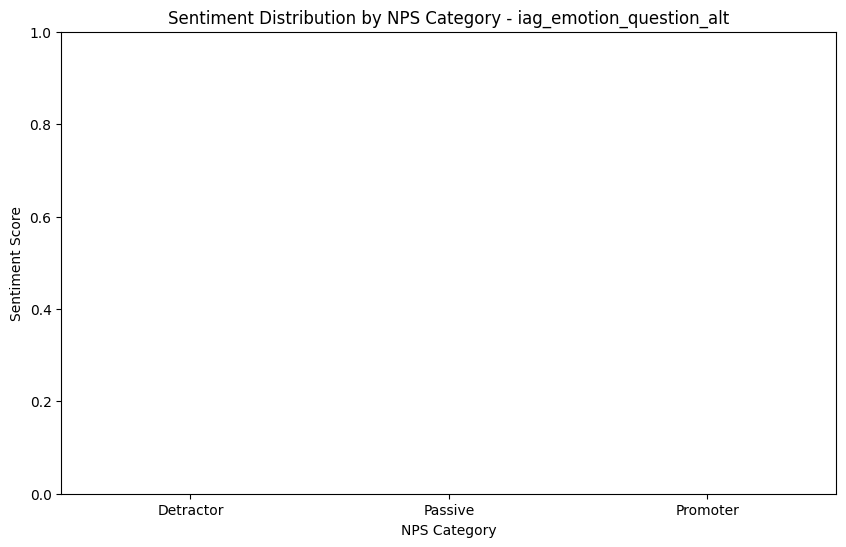


Top 20 most important words in iag_emotion_question_alt:
           word  tfidf_score
3   contentment     0.310341
10        trust     0.253130
4     happiness     0.187608
1     annoyance     0.056131
9      surprise     0.040911
2       anxiety     0.030440
0         anger     0.018243
6         pride     0.015544
5          love     0.011658
7       sadness     0.010255
8         shame     0.003454

Correlation between comment sentiments and likelihood to recommend:
Empty DataFrame
Columns: [iag_reason_ltr_comment, iag_additional_cmt_comment, iag_emotion_question_alt]
Index: []


In [9]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import matplotlib.pyplot as plt
from textblob import TextBlob
import re

# Read the dataset
df = pd.read_excel('../../data/IAG.xlsx')

# Convert 'Likely to recommend' to numeric, errors='coerce' will convert non-numeric values to NaN
df['Likely to recommend'] = pd.to_numeric(df['Likely to recommend'], errors='coerce')

# Check missing values in comment columns
comment_cols = ['iag_reason_ltr_comment', 'iag_additional_cmt_comment', 'iag_emotion_question_alt']
missing_analysis = df[comment_cols].isnull().sum()
missing_percentage = (missing_analysis / len(df)) * 100

# Function to clean text
def clean_text(text):
    if pd.isna(text):
        return ""
    text = str(text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    text = ' '.join(text.split())
    return text

# Clean all comment columns
for col in comment_cols:
    df[f'{col}_cleaned'] = df[col].apply(clean_text)

# Sentiment Analysis
def get_sentiment(text):
    if text == "":
        return 0
    return TextBlob(text).sentiment.polarity

# Calculate sentiment for each comment column
for col in comment_cols:
    df[f'{col}_sentiment'] = df[f'{col}_cleaned'].apply(get_sentiment)

# Create NPS categories using the correct column name
df['nps_category'] = pd.cut(df['Likely to recommend'], 
                           bins=[-np.inf, 6, 8, np.inf],
                           labels=['Detractor', 'Passive', 'Promoter'])

# Most common words analysis using TF-IDF
tfidf = TfidfVectorizer(max_features=20, stop_words='english')

def analyze_top_words(column_name):
    if df[f'{column_name}_cleaned'].str.strip().str.len().gt(0).sum() == 0:
        return pd.DataFrame()
    
    tfidf_matrix = tfidf.fit_transform(df[f'{column_name}_cleaned'])
    feature_names = tfidf.get_feature_names_out()
    mean_tfidf = tfidf_matrix.mean(axis=0).A1
    return pd.DataFrame({
        'word': feature_names,
        'tfidf_score': mean_tfidf
    }).sort_values('tfidf_score', ascending=False)

# Analyze relationship with NPS
def plot_sentiment_nps_relationship(df, comment_col):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='nps_category', y=f'{comment_col}_sentiment', data=df)
    plt.title(f'Sentiment Distribution by NPS Category - {comment_col}')
    plt.xlabel('NPS Category')
    plt.ylabel('Sentiment Score')
    plt.show()

# Generate visualizations
for col in comment_cols:
    plot_sentiment_nps_relationship(df, col)
    top_words = analyze_top_words(col)
    if not top_words.empty:
        print(f"\nTop 20 most important words in {col}:")
        print(top_words)

# Calculate correlation between sentiment and likelihood to recommend
sentiment_correlation = pd.DataFrame()
for col in comment_cols:
    sentiment_correlation[col] = df[f'{col}_sentiment'].corr(df['Likely to recommend'])

print("\nCorrelation between comment sentiments and likelihood to recommend:")
print(sentiment_correlation)
